
# Diabetes Risk Modeling — Clean 5k CSV + K‑Fold CV
This notebook:
- Loads your **5,000‑row CSV** SANPLE
- Builds **Logistic Regression**, **RandomForest**, **XGBoost (optional)**, and a **Neural Net** (pure Keras adapter)
- Uses **dense one‑hot** with tidy preprocessors
- Evaluates with **PR‑optimal threshold**
- Adds **diagnostic plots**, **save helpers**, **(optional) calibration**, and **5‑fold stratified CV**


## 1) Environment sanity (versions & stable threading)

In [1]:

import os
os.environ["JOBLIB_MULTIPROCESSING"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

from sklearn import set_config
set_config(transform_output="default")  

import numpy as np, pandas as pd, sklearn
print("Versions -> numpy:", np.__version__, "| pandas:", pd.__version__, "| sklearn:", sklearn.__version__)


Versions -> numpy: 2.3.2 | pandas: 2.3.1 | sklearn: 1.7.1


## 2) Load the existing CSV

In [2]:

import pandas as pd
from pathlib import Path

CSV_PATHS = [
    "diabetes_sample_5000.csv",    
       
]
TARGET_COL = "diabetes_label"

csv_path = next((p for p in CSV_PATHS if Path(p).exists()), None)
if csv_path is None:
    raise FileNotFoundError("CSV not found. Upload 'diabetes_sample_5000.csv' to /content/ or edit CSV_PATHS.")

print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Got: {list(df.columns)}")

print("Shape:", df.shape, "  Target prevalence:", round(df[TARGET_COL].mean(), 3))
df.head(3)


Using CSV: diabetes_sample_5000.csv
Shape: (5000, 9)   Target prevalence: 0.297


,age,gender,bmi,glucose_fasting,insulin_fasting,c_peptide_fasting,ogtt_1h_glucose,ogtt_2h_glucose,diabetes_label
0,25.0,Male,26.726487,101.125908,10.594055,2.154686,137.379615,91.466499,0
1,66.0,Female,22.345320,103.123759,11.926012,1.179879,119.079226,134.490294,0
2,59.0,Female,26.953287,83.984525,13.899373,1.206696,111.779009,134.116576,0


In [3]:

def data_quality_report(df):
    print("=== DATA QUALITY REPORT ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    # Check for outliers
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\nOutliers check:")
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
        print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

# Run the data quality check
data_quality_report(df)

=== DATA QUALITY REPORT ===
Dataset shape: (5000, 9)
Missing values:
age                  0
gender               0
bmi                  0
glucose_fasting      0
insulin_fasting      0
c_peptide_fasting    0
ogtt_1h_glucose      0
ogtt_2h_glucose      0
diabetes_label       0
dtype: int64
Duplicate rows: 0

Outliers check:
age: 0 outliers (0.0%)
bmi: 24 outliers (0.5%)
glucose_fasting: 20 outliers (0.4%)
insulin_fasting: 93 outliers (1.9%)
c_peptide_fasting: 82 outliers (1.6%)
ogtt_1h_glucose: 30 outliers (0.6%)
ogtt_2h_glucose: 6 outliers (0.1%)
diabetes_label: 0 outliers (0.0%)


## 3) Dynamic feature selection

In [4]:

ID_LIKE = {"id", "patient_id"}
def pick_feature_columns(df, target_col=TARGET_COL, exclude_like=ID_LIKE):
    cols = [c for c in df.columns if c != target_col]
    cols = [c for c in cols if c.lower() not in exclude_like and not c.lower().endswith("id")]
    return cols

feature_cols = pick_feature_columns(df)
print("Selected features:", feature_cols)


Selected features: ['age', 'gender', 'bmi', 'glucose_fasting', 'insulin_fasting', 'c_peptide_fasting', 'ogtt_1h_glucose', 'ogtt_2h_glucose']


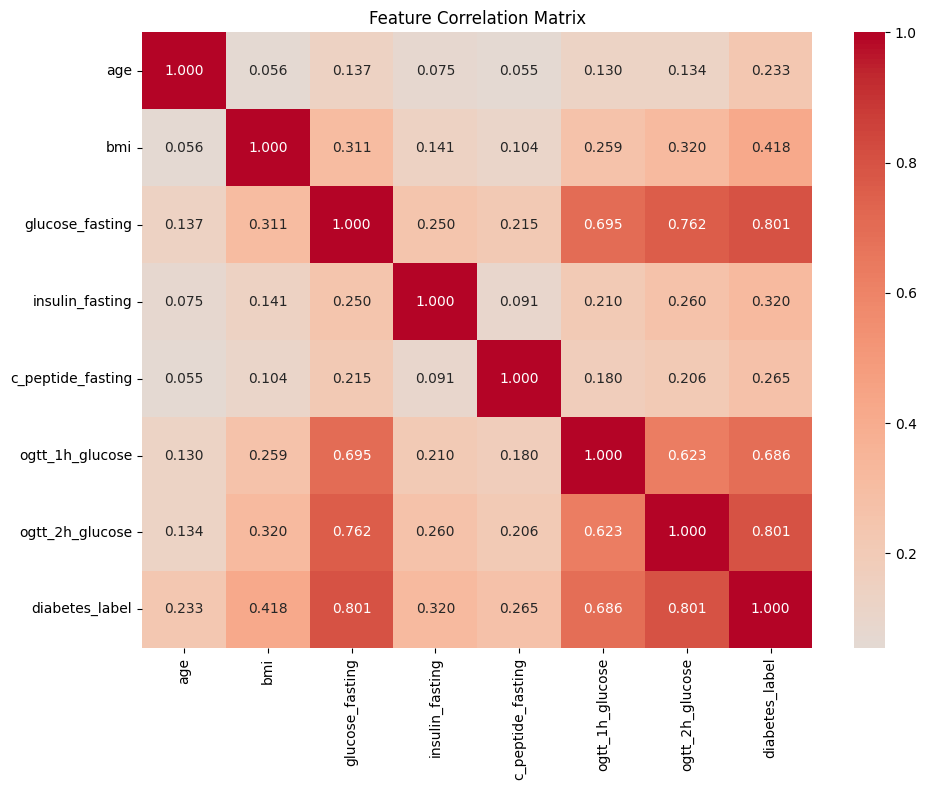

Strongest correlations with diabetes_label:
diabetes_label: 1.000
glucose_fasting: 0.801
ogtt_2h_glucose: 0.801
ogtt_1h_glucose: 0.686
bmi: 0.418
insulin_fasting: 0.320
c_peptide_fasting: 0.265
age: 0.233


In [5]:
# Feature Correlation Analysis
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(df, target_col, feature_cols):

    cols_to_analyze = feature_cols + [target_col]
    numeric_cols = [c for c in cols_to_analyze if df[c].dtype in ['float64', 'int64']]
    
    corr_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Show target correlations
    target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
    print(f"Strongest correlations with {target_col}:")
    for feature, corr in target_corr.head(8).items():
        print(f"{feature}: {corr:.3f}")


plot_correlation_matrix(df, TARGET_COL, feature_cols)

## 4) Train/Test split (stratified)

In [6]:

from sklearn.model_selection import train_test_split

X = df[feature_cols].copy()
y = df[TARGET_COL].astype(int).copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Class balance train/test:", round(y_train.mean(),3), round(y_test.mean(),3))


Train: (4000, 8)  Test: (1000, 8)
Class balance train/test: 0.297 0.297


## 5) Preprocessors (dense OneHotEncoder)

In [7]:

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pandas.api.types import is_object_dtype, CategoricalDtype

cat_cols = [c for c in X_train.columns if is_object_dtype(X_train[c]) or isinstance(X_train[c].dtype, CategoricalDtype)]
num_cols = [c for c in X_train.columns if c not in cat_cols]

# Linear-friendly
pre_linear = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
], remainder="drop")

# Tree-friendly
pre_tree = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
], remainder="drop")

# NN-friendly (same as linear but dense OHE is important)
pre_nn = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
], remainder="drop")

print("num_cols:", num_cols)
print("cat_cols:", cat_cols)


num_cols: ['age', 'bmi', 'glucose_fasting', 'insulin_fasting', 'c_peptide_fasting', 'ogtt_1h_glucose', 'ogtt_2h_glucose']
cat_cols: ['gender']


## 6) Evaluation utilities + diagnostics

In [31]:

import numpy as np
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             precision_recall_curve, precision_score, recall_score, confusion_matrix)
import matplotlib.pyplot as plt

def pr_opt_threshold(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    if len(thr) <= 1:
        return 0.5
    J = prec + rec - 1
    return float(thr[np.argmax(J[:-1])])

def evaluate_model(model, X_te, y_te, name="Model"):
    proba = model.predict_proba(X_te)[:, 1]
    thr = pr_opt_threshold(y_te, proba)
    pred = (proba >= thr).astype(int)
    auroc = roc_auc_score(y_te, proba)
    ap    = average_precision_score(y_te, proba)
    brier = brier_score_loss(y_te, proba)
    prev  = float(np.mean(y_te))
    prec0 = precision_score(y_te, pred, zero_division=0)
    rec0  = recall_score(y_te, pred, zero_division=0)
    lift  = (prec0/prev) if prev>0 else float("nan")
    print(f"[{name}] AUROC={auroc:.4f}  AP={ap:.4f}  Prec={prec0:.3f}  Rec={rec0:.3f}  "
          f"Brier={brier:.4f}  Prev={prev:.3f}  Thr={thr:.3f}  Lift={lift:.2f}x")
    return dict(name=name, auroc=auroc, ap=ap, precision=prec0, recall=rec0,
                brier=brier, prev=prev, thr=thr, lift=lift)

def diag_plots(model, X, y, title="Model"):
    proba = model.predict_proba(X)[:,1]
    cm = confusion_matrix(y, (proba >= 0.5).astype(int))
    print("Confusion matrix @0.50:\n", cm)
    prec, rec, _ = precision_recall_curve(y, proba)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve — {title}")
    plt.grid(True); plt.show()


## 7) Train & evaluate models

### 7.a) Logistic Regression

In [9]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([
    ("pre", pre_linear),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"))
])
lr_pipeline.fit(X_train, y_train)
metrics_lr = evaluate_model(lr_pipeline, X_test, y_test, name="LogisticRegression")
# diag_plots(lr_pipeline, X_test, y_test, title="LogisticRegression")


[LogisticRegression] AUROC=0.9985  AP=0.9970  Prec=0.983  Rec=0.976  Brier=0.0178  Prev=0.297  Thr=0.823  Lift=3.31x


### 7.b) RandomForest

In [10]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_pipeline = Pipeline([
    ("pre", pre_tree),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=1,              
        random_state=42,
    ))
])
rf_pipeline.fit(X_train, y_train)
metrics_rf = evaluate_model(rf_pipeline, X_test, y_test, name="RandomForest")
# diag_plots(rf_pipeline, X_test, y_test, title="RandomForest")


[RandomForest] AUROC=0.9983  AP=0.9964  Prec=0.967  Rec=0.980  Brier=0.0161  Prev=0.297  Thr=0.495  Lift=3.26x


### 7.c) XGBoost 

In [11]:

try:
    import xgboost as xgb
    from sklearn.pipeline import Pipeline
    xgb_pipeline = Pipeline([
        ("pre", pre_tree),
        ("clf", xgb.XGBClassifier(
            tree_method="hist",          # use "gpu_hist" + predictor="gpu_predictor" if GPU is available
            n_estimators=800, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            reg_lambda=1.0, random_state=42, eval_metric="auc", n_jobs=1
        ))
    ])
    xgb_pipeline.fit(X_train, y_train)
    metrics_xgb = evaluate_model(xgb_pipeline, X_test, y_test, name="XGBoost")
   
except Exception as e:
    print("XGBoost unavailable:", e)
    metrics_xgb = None


[XGBoost] AUROC=0.9986  AP=0.9973  Prec=0.964  Rec=0.987  Brier=0.0130  Prev=0.297  Thr=0.539  Lift=3.25x


### 7.d) Neural Net (pure Keras adapter)

In [12]:

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    import numpy as np
    np.random.seed(42); tf.random.set_seed(42)

    # Fit preprocessor and transform
    Xtr = pre_nn.fit_transform(X_train)
    Xte = pre_nn.transform(X_test)
    n_in = Xtr.shape[1]

    def build_mlp(n_in, hidden=(256,128), dropout=0.15, lr=1e-3):
        inp = keras.Input(shape=(n_in,))
        x = inp
        for h in hidden:
            x = layers.Dense(h, activation="relu")(x)
            x = layers.Dropout(dropout)(x)
        out = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inp, out)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                      loss="binary_crossentropy",
                      metrics=[keras.metrics.AUC(name="auc"),
                               keras.metrics.AUC(name="auprc", curve="PR")])
        return model

    pos_rate = float(y_train.mean())
    class_weight = {0: 1.0, 1: (1.0 / max(pos_rate, 1e-6))}
    early_stop = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)

    nn_model = build_mlp(n_in)
    nn_model.fit(Xtr, y_train.values, epochs=30, batch_size=1024, validation_split=0.1,
                 class_weight=class_weight, callbacks=[early_stop], verbose=0)

    class KerasAdapter:
        def __init__(self, model, pre): self.model, self.pre = model, pre
        def predict_proba(self, X):
            import numpy as np
            Xp = self.pre.transform(X)
            p = self.model.predict(Xp, batch_size=1024, verbose=0).ravel()
            return np.c_[1 - p, p]

    nn_adapter = KerasAdapter(nn_model, pre_nn)
    metrics_nn = evaluate_model(nn_adapter, X_test, y_test, name="NeuralNet (Keras)")
    # diag_plots(nn_adapter, X_test, y_test, title="NeuralNet (Keras)")
except Exception as e:
    print("TensorFlow unavailable or errored:", e)
    metrics_nn = None


c:\Users\almutirial\Desktop\AI\final\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\almutirial\Desktop\AI\final\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\almutirial\Desktop\AI\final\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please upd

[NeuralNet (Keras)] AUROC=0.9973  AP=0.9947  Prec=0.983  Rec=0.960  Brier=0.0918  Prev=0.297  Thr=0.757  Lift=3.31x


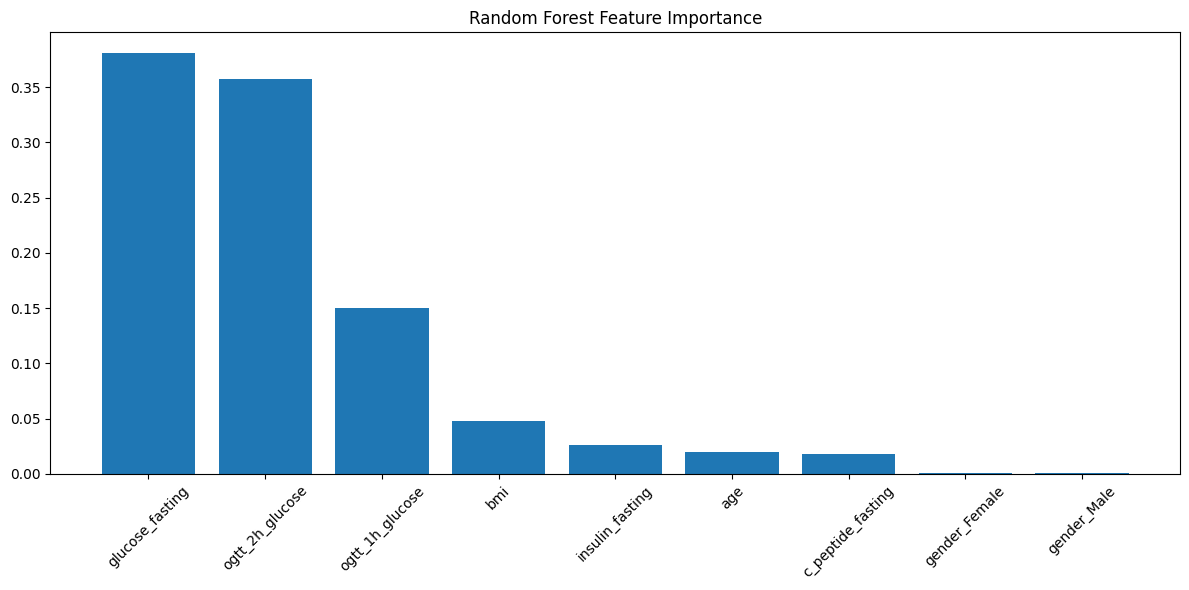

In [13]:
# Feature Importance Plot
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    # feature names after preprocessing
    preprocessor = model.named_steps['pre']
    # Fit preprocessor to get feature names
    preprocessor.fit(X_train)
    
    # Get feature names from the column transformer
    feature_names_out = []
    for name, transformer, features in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names_out.extend(transformer.get_feature_names_out())
            else:
                feature_names_out.extend(features)
    
    importance = model.named_steps['clf'].feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title(f"{title}")
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), 
              [feature_names_out[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_pipeline, feature_cols, "Random Forest Feature Importance")

## 8) Models comparison

In [14]:

import pandas as pd
rows = []
for m in ("metrics_lr", "metrics_rf", "metrics_xgb", "metrics_nn"):
    if m in globals() and globals()[m] is not None:
        rows.append(globals()[m])
cmp_df = pd.DataFrame(rows).set_index("name")
display(cmp_df.sort_values("auroc", ascending=False))


,auroc,ap,precision,recall,brier,prev,thr,lift
name,,,,,,,,
XGBoost,0.998635,0.997262,0.963816,0.986532,0.013009,0.297,0.538871,3.245171
LogisticRegression,0.998530,0.997019,0.983051,0.976431,0.017825,0.297,0.822617,3.309936
RandomForest,0.998319,0.996395,0.966777,0.979798,0.016111,0.297,0.494535,3.255143
NeuralNet (Keras),0.997251,0.994749,0.982759,0.959596,0.091785,0.297,0.757187,3.308952


## 9) Save models & predictions

In [15]:

# import joblib, pandas as pd, numpy as np
# def save_model(obj, path):
#     joblib.dump(obj, path); print("Saved model ->", path)

# def save_preds(model, X, y, path="test_predictions.csv"):
#     p = model.predict_proba(X)[:,1]
#     pd.DataFrame({"y_true": y.values, "y_proba": p}).to_csv(path, index=False)
#     print("Saved predictions ->", path)

# # Examples (uncomment to use):
# # save_model(lr_pipeline, "model_logreg.joblib")
# # save_model(rf_pipeline, "model_rf.joblib")
# # if 'xgb_pipeline' in globals(): save_model(xgb_pipeline, "model_xgb.joblib")
# # if 'nn_adapter' in globals(): save_model(nn_adapter, "model_nn_adapter.joblib")
# # save_preds(lr_pipeline, X_test, y_test, "lr_test_preds.csv")


## 10) Probability calibration for LR

In [16]:

from sklearn.calibration import CalibratedClassifierCV

cal_lr = CalibratedClassifierCV(lr_pipeline, method="isotonic", cv=3)
cal_lr.fit(X_train, y_train)
metrics_lr_cal = evaluate_model(cal_lr, X_test, y_test, name="LogReg+Isotonic")


[LogReg+Isotonic] AUROC=0.9985  AP=0.9966  Prec=0.993  Rec=0.966  Brier=0.0134  Prev=0.297  Thr=0.835  Lift=3.34x


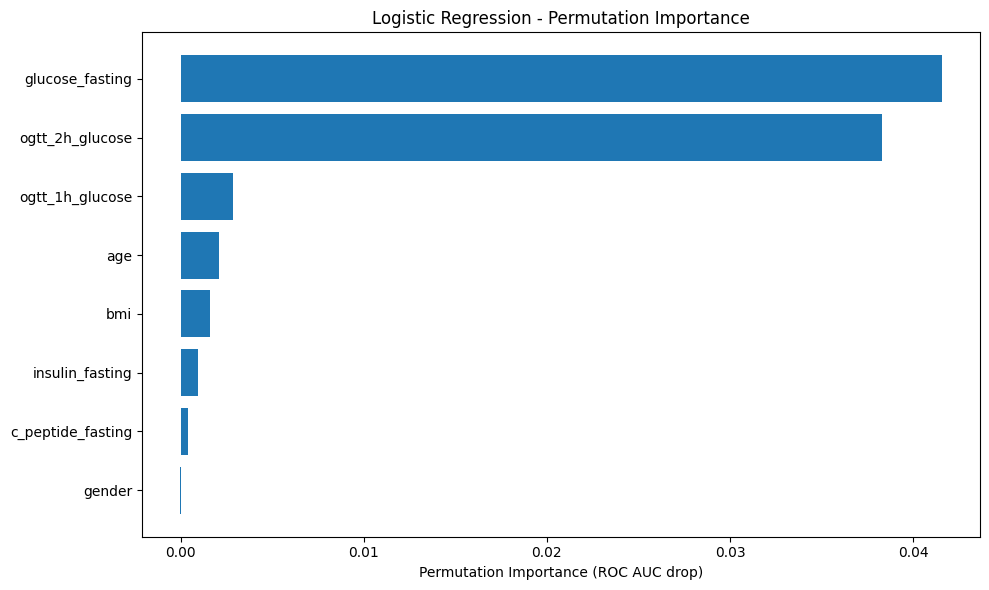

In [17]:
# Model Interpretation with Permutation Importance
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X_test, y_test, title="Permutation Importance"):
    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        scoring='roc_auc', 
        n_repeats=5, 
        random_state=42,
        n_jobs=1
    )
    
    feature_names = X_test.columns
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"{title}")
    plt.barh(range(len(indices)), perm_importance.importances_mean[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Permutation Importance (ROC AUC drop)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Plot for your best model
plot_permutation_importance(lr_pipeline, X_test, y_test, "Logistic Regression - Permutation Importance")

## 11) Drift & prevalence check

In [18]:

print("Train prevalence:", round(y_train.mean(),3), " | Test prevalence:", round(y_test.mean(),3))


Train prevalence: 0.297  | Test prevalence: 0.297


## 12) 5‑Fold Stratified Cross‑Validation

In [19]:

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, brier_score_loss

# Use threshold-free scorers for CV (probability metrics)
scoring = {
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",
    "neg_brier": "neg_brier_score",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_summary(name, estimator, X, y):
    # Avoid multi-processing after pip changes: use n_jobs=1
    out = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    import numpy as np, pandas as pd
    s = {f"{k}_mean": np.mean(v) for k, v in out.items() if k.startswith("test_") for v in [out[k]]}
    sd = {f"{k}_std": np.std(v) for k, v in out.items() if k.startswith("test_") for v in [out[k]]}
    row = {"name": name}
    row.update({k.replace("test_", ""): v for k, v in s.items()})
    row.update({k.replace("test_", ""): v for k, v in sd.items()})
    return row

rows = []
rows.append(cv_summary("LogisticRegression", lr_pipeline, X, y))
rows.append(cv_summary("RandomForest", rf_pipeline, X, y))
try:
    rows.append(cv_summary("XGBoost", xgb_pipeline, X, y))
except:
    pass
# NN CV skipped by default (heavier); you can add similarly using the adapter and pre_nn

import pandas as pd
cv_df = pd.DataFrame(rows).set_index("name")
display(cv_df)


,roc_auc_mean,average_precision_mean,neg_brier_mean,roc_auc_std,average_precision_std,neg_brier_std
name,,,,,,
LogisticRegression,0.998091,0.995838,-0.016236,0.000353,0.000696,0.001938
RandomForest,0.996992,0.993353,-0.018819,0.000850,0.001737,0.002317
XGBoost,0.997351,0.994072,-0.018179,0.000580,0.001307,0.003178


In [ ]:
# Hyperparameter Tuning (Optional - Run if you want to optimize)
from sklearn.model_selection import GridSearchCV

def quick_rf_tuning(X_train, y_train):
    """Quick hyperparameter tuning for Random Forest"""
    # Smaller grid for speed
    param_grid = {
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [10, None],
        'clf__min_samples_leaf': [1, 2]
    }
    
    rf_pipeline_tune = Pipeline([
        ("pre", pre_tree),
        ("clf", RandomForestClassifier(
            class_weight="balanced_subsample",
            n_jobs=1, 
            random_state=42
        ))
    ])
    
    grid_search = GridSearchCV(
        rf_pipeline_tune, 
        param_grid, 
        cv=3,  # Faster with 3-fold
        scoring='roc_auc',
        n_jobs=1,
        verbose=1
    )
    
    print("Tuning Random Forest (this may take a few minutes)...")
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Uncomment to run hyperparameter tuning
best_rf = quick_rf_tuning(X_train, y_train)
metrics_rf_tuned = evaluate_model(best_rf, X_test, y_test, name="RandomForest-Tuned")

Tuning Random Forest (this may take a few minutes)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 400}
Best CV score: 0.9966
[RandomForest-Tuned] AUROC=0.9982  AP=0.9962  Prec=0.970  Rec=0.980  Brier=0.0164  Prev=0.297  Thr=0.502  Lift=3.27x


<!-- ## 13) GPU & DW notes -->


- **GPU**: Enable GPU runtime, increase NN `batch_size` (e.g., 4096–8192), and in XGBoost set `tree_method="gpu_hist"` + `predictor="gpu_predictor"`.
- **Data Warehouse**: Replace the CSV load with your connector (Snowflake/BigQuery/Postgres) and keep the same pipeline/eval cells.


## ✅ Train / Validation / Test split (stratified)

In [21]:

# If you already have X_train / X_val defined, this cell will skip.
try:
    _ = (X_train, X_val, X_test, y_train, y_val, y_test)
    print("Existing Train/Val/Test found — skipping new split.")
except NameError:
    import pandas as pd
    from sklearn.model_selection import train_test_split

    # Try to detect target col
    TARGET_COL = "diabetes_label" if "diabetes_label" in df.columns else (
        "target" if "target" in df.columns else None
    )
    if TARGET_COL is None:
        raise ValueError("Couldn't detect target column. Make sure df has 'diabetes_label' (or set TARGET_COL).")

    X_full = df.drop(columns=[TARGET_COL]).copy()
    y_full = df[TARGET_COL].astype(int).copy()

    # First: Train+Val vs Test (80/20)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
    )
    # Second: Train vs Validation (80/20 of the train portion -> total 64/16/20)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
    )

    print(f"Train: {X_train.shape},  Val: {X_val.shape},  Test: {X_test.shape}")
    print(f"Prev — Train: {y_train.mean():.3f} | Val: {y_val.mean():.3f} | Test: {y_test.mean():.3f}")


Train: (3200, 8),  Val: (800, 8),  Test: (1000, 8)
Prev — Train: 0.297 | Val: 0.297 | Test: 0.297


## 📊 Quick EDA plots

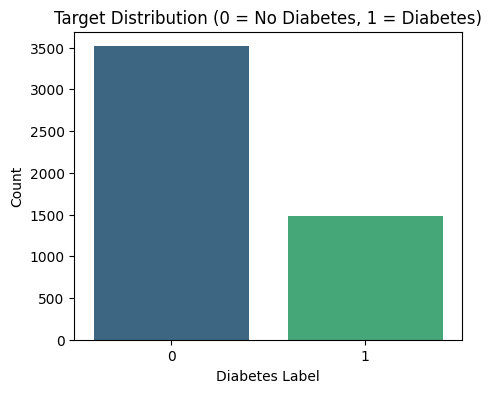

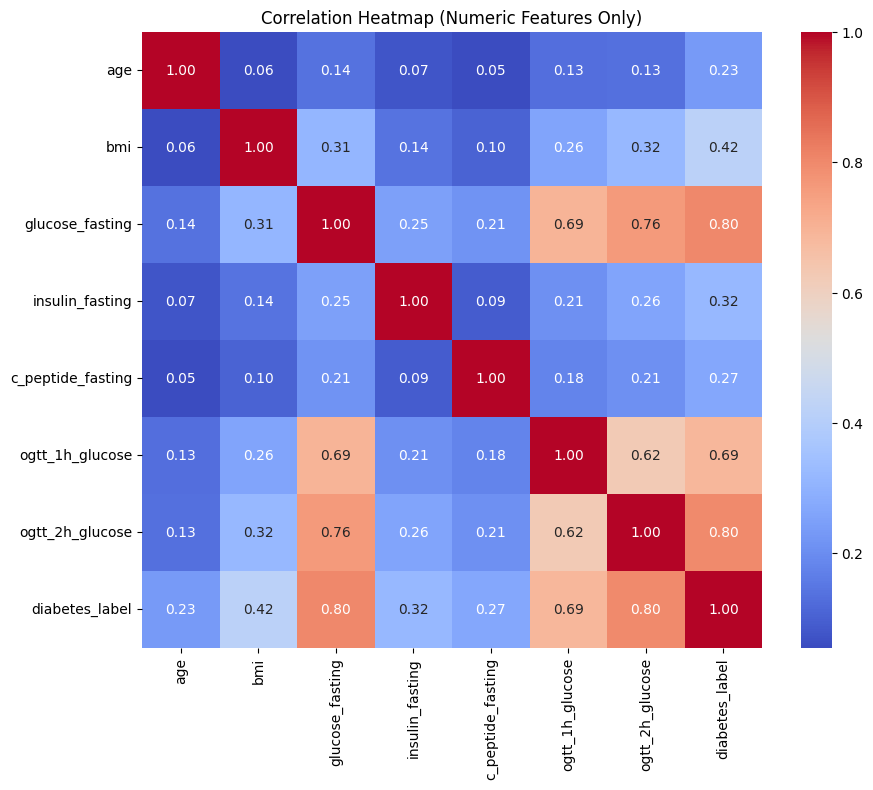

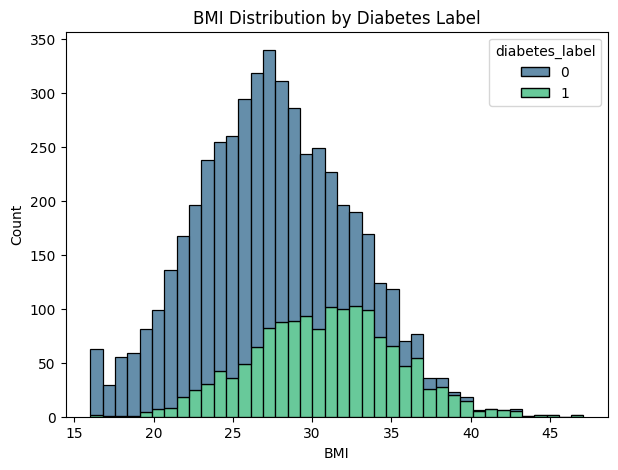

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x=y_full, hue=y_full, palette="viridis", legend=False)
plt.title("Target Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.xlabel("Diabetes Label"); plt.ylabel("Count")
plt.show()

# 2) Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# 3) BMI distribution by label (if BMI present)
if "bmi" in df.columns:
    plt.figure(figsize=(7,5))
    sns.histplot(data=df, x="bmi", hue="diabetes_label", multiple="stack", palette="viridis")
    plt.title("BMI Distribution by Diabetes Label"); plt.xlabel("BMI"); plt.ylabel("Count")
    plt.show()
else:
    print("Column 'bmi' not found — skipping BMI plot.")


## 🔎 Pairplot (subset of numeric features)

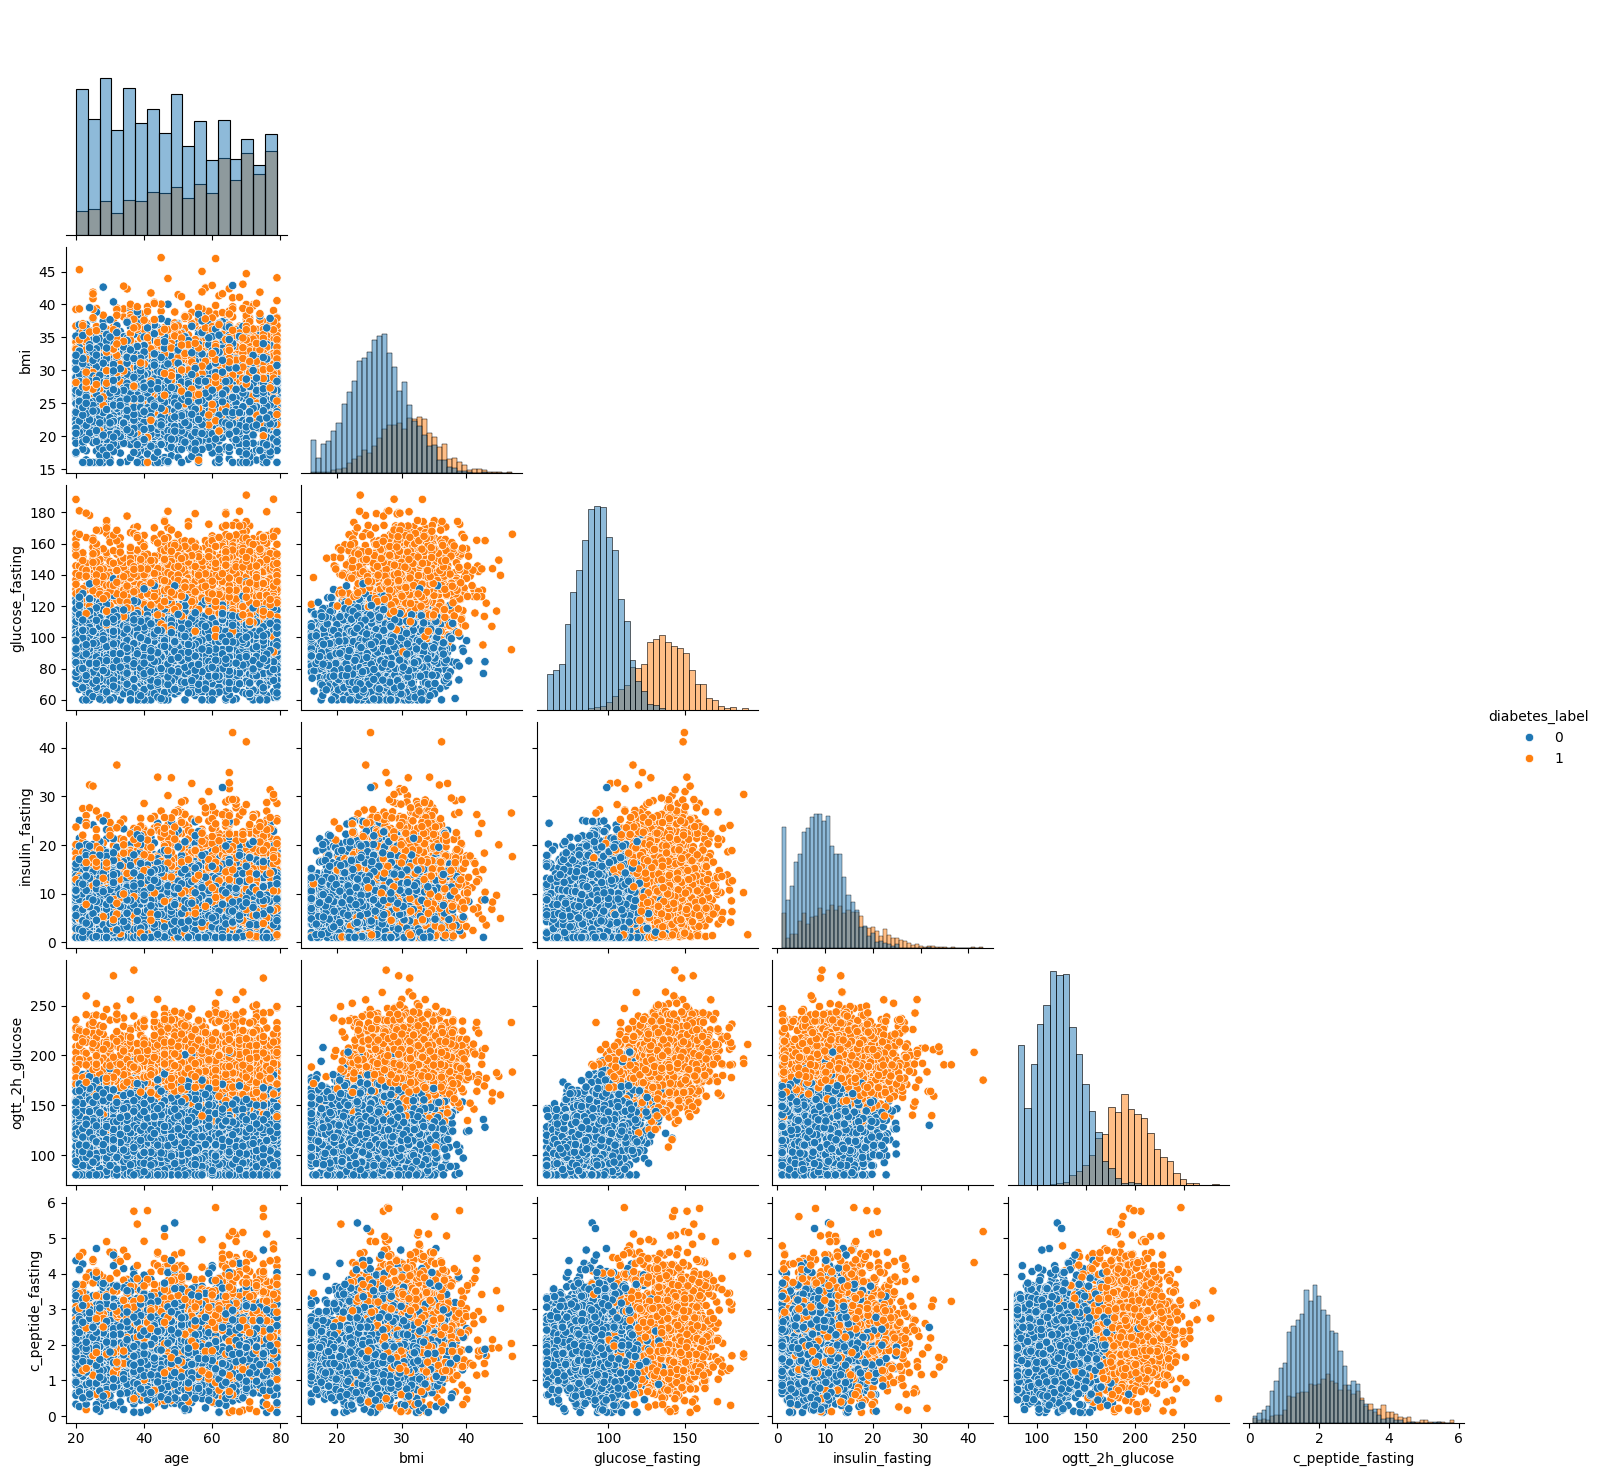

In [23]:

import seaborn as sns
import pandas as pd

# Select up to 6 numeric features + target for a readable pairplot
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "diabetes_label"]
subset = ["age","bmi","glucose_fasting","insulin_fasting","ogtt_2h_glucose","c_peptide_fasting"]
subset = [c for c in subset if c in num_cols][:6]
if "diabetes_label" in df.columns:
    plot_df = df[subset + ["diabetes_label"]].copy()
    sns.pairplot(plot_df, hue="diabetes_label", corner=True, diag_kind="hist")
else:
    plot_df = df[subset].copy()
    sns.pairplot(plot_df, corner=True, diag_kind="hist")
plt.show()


## 🎯 Validation-based threshold tuning + PR/ROC curves

Chosen threshold from Validation: 0.916


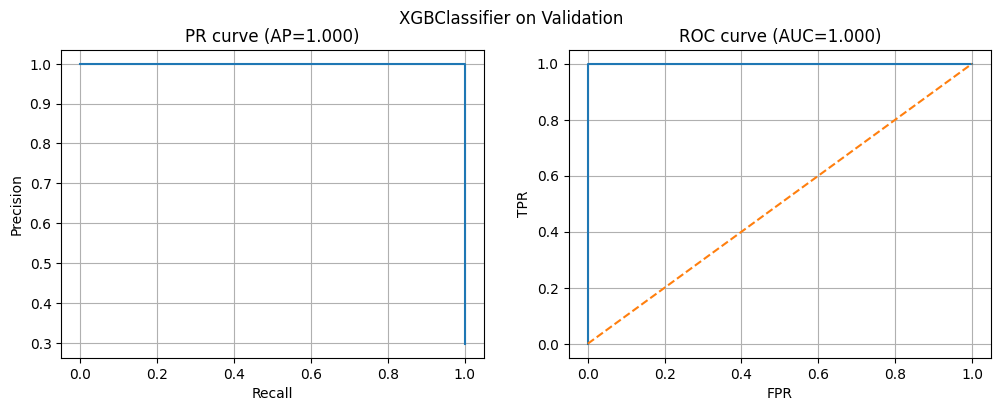

In [24]:

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def pr_opt_threshold(y_true, proba):
    p, r, t = precision_recall_curve(y_true, proba)
    if len(t) <= 1: 
        return 0.5, p, r, t
    J = p + r - 1
    return float(t[np.argmax(J[:-1])]), p, r, t

def plot_pr_roc(y_true, proba, title="Model on Validation"):
    # PR
    p, r, _ = precision_recall_curve(y_true, proba)
    ap = auc(r, p)
    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    roc = auc(fpr, tpr)

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(r, p); ax[0].set_xlabel("Recall"); ax[0].set_ylabel("Precision"); ax[0].set_title(f"PR curve (AP={ap:.3f})")
    ax[0].grid(True)
    ax[1].plot(fpr, tpr); ax[1].plot([0,1],[0,1],'--'); ax[1].set_xlabel("FPR"); ax[1].set_ylabel("TPR"); ax[1].set_title(f"ROC curve (AUC={roc:.3f})")
    ax[1].grid(True); plt.suptitle(title); plt.show()

# Choose a model already trained in your notebook; fall back to logistic if present
chosen = None
for name in ["xgb_pipeline", "rf_pipeline", "lr_pipeline"]:
    if name in globals():
        chosen = globals()[name]
        break

if chosen is None:
    print("No trained model pipeline found (expected one of: xgb_pipeline, rf_pipeline, lr_pipeline). Train a model first.")
else:
    proba_val = chosen.predict_proba(X_val)[:,1]
    thr_opt, p, r, t = pr_opt_threshold(y_val, proba_val)
    print(f"Chosen threshold from Validation: {thr_opt:.3f}")
    plot_pr_roc(y_val, proba_val, title=f"{type(chosen.named_steps.get('clf', chosen)).__name__} on Validation")


## 🧭 Feature importances / coefficients

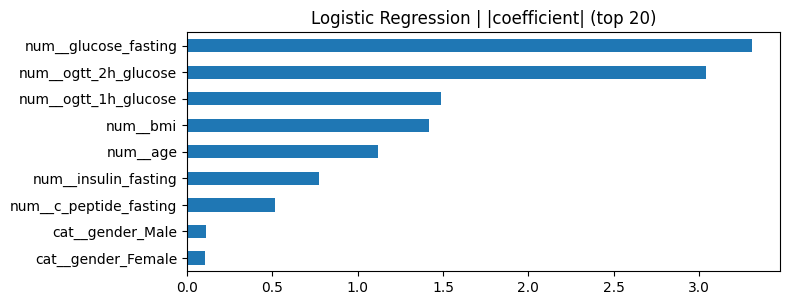

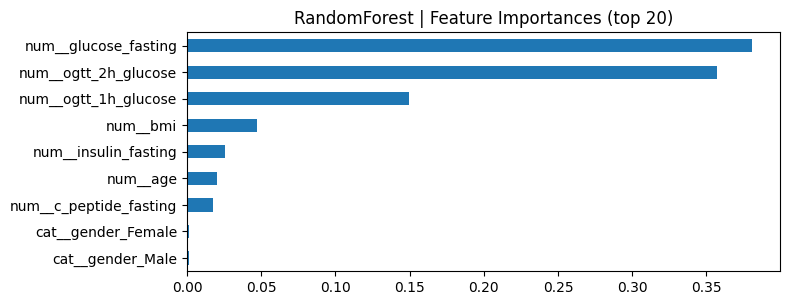

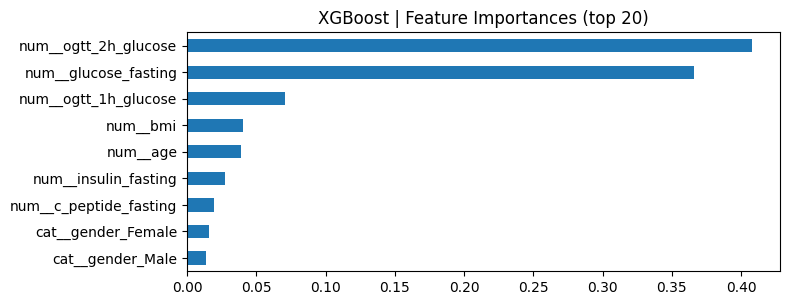

In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_feature_names(ct):
    # Try standard get_feature_names_out
    try:
        return list(ct.get_feature_names_out())
    except Exception:
        # Fallback: build names manually (limited)
        names = []
        for name, trans, cols in ct.transformers_:
            if name == "remainder":
                continue
            if hasattr(trans, "get_feature_names_out"):
                try:
                    part = list(trans.get_feature_names_out(cols))
                except Exception:
                    part = cols if isinstance(cols, list) else [cols]
            else:
                part = cols if isinstance(cols, list) else [cols]
            names.extend(part)
        return names

def plot_top_series(s, title, k=20):
    s = s.sort_values(ascending=False).head(k)
    plt.figure(figsize=(8, max(3, 0.35*len(s))))
    s[::-1].plot(kind="barh")
    plt.title(title); plt.tight_layout(); plt.show()

plotted = False

# Logistic regression coefficients
if "lr_pipeline" in globals():
    pre = lr_pipeline.named_steps.get("pre", None)
    clf = lr_pipeline.named_steps.get("clf", None)
    if pre is not None and clf is not None and hasattr(clf, "coef_"):
        fn = get_feature_names(pre)
        coefs = pd.Series(np.abs(clf.coef_.ravel()), index=fn)
        plot_top_series(coefs, "Logistic Regression | |coefficient| (top 20)")
        plotted = True

# RandomForest feature importances
if "rf_pipeline" in globals():
    pre = rf_pipeline.named_steps.get("pre", None)
    clf = rf_pipeline.named_steps.get("clf", None)
    if pre is not None and clf is not None and hasattr(clf, "feature_importances_"):
        fn = get_feature_names(pre)
        imps = pd.Series(clf.feature_importances_, index=fn)
        plot_top_series(imps, "RandomForest | Feature Importances (top 20)")
        plotted = True

# XGBoost feature importances
if "xgb_pipeline" in globals():
    pre = xgb_pipeline.named_steps.get("pre", None)
    clf = xgb_pipeline.named_steps.get("clf", None)
    if pre is not None and clf is not None and hasattr(clf, "feature_importances_"):
        fn = get_feature_names(pre)
        imps = pd.Series(clf.feature_importances_, index=fn)
        plot_top_series(imps, "XGBoost | Feature Importances (top 20)")
        plotted = True

if not plotted:
    print("Train a model (LR / RF / XGB) before running this cell to see feature importance.")


## 📈 Learning curve (Logistic Regression example)

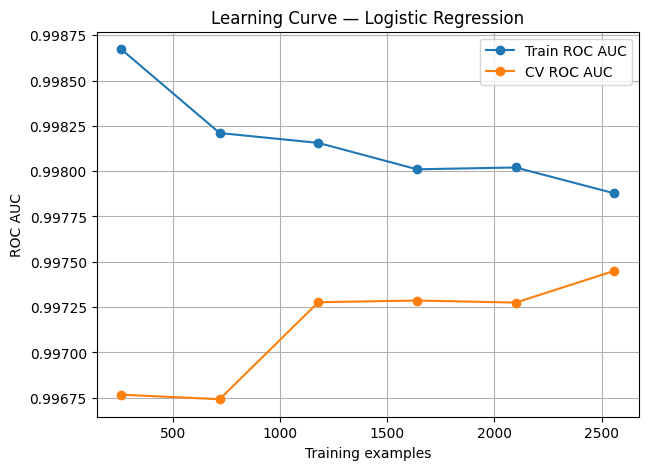

In [26]:

from sklearn.model_selection import learning_curve, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

if "lr_pipeline" not in globals():
    print("Train lr_pipeline first to run learning curve.")
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        lr_pipeline, X_train, y_train, cv=cv,
        scoring="roc_auc", n_jobs=1,
        train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, marker="o", label="Train ROC AUC")
    plt.plot(train_sizes, test_mean, marker="o", label="CV ROC AUC")
    plt.xlabel("Training examples"); plt.ylabel("ROC AUC")
    plt.title("Learning Curve — Logistic Regression")
    plt.legend(); plt.grid(True); plt.show()


## 🛠️ Validation curve (RandomForest max_depth example)

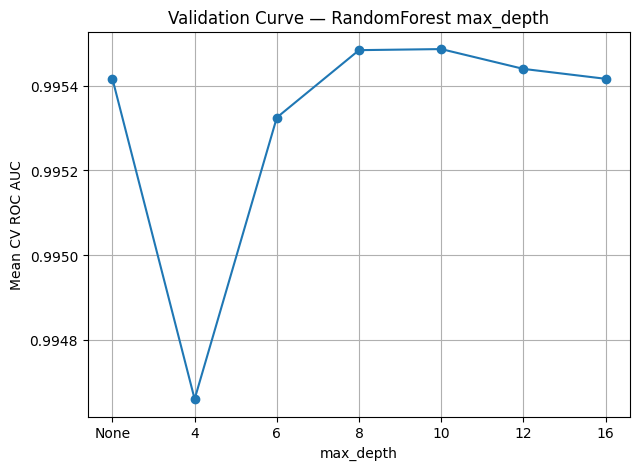

In [27]:

from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt

if "rf_pipeline" not in globals():
    print("Train rf_pipeline first to run validation curve.")
else:
    # vary max_depth
    depths = [None, 4, 6, 8, 10, 12, 16]
    # Build estimators with different depths
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    estimators = []
    for d in depths:
        est = Pipeline([
            ("pre", rf_pipeline.named_steps["pre"]),
            ("clf", RandomForestClassifier(
                n_estimators=400, max_depth=d, min_samples_leaf=2,
                class_weight="balanced_subsample", n_jobs=1, random_state=42
            ))
        ])
        estimators.append(est)

    # Evaluate each with Stratified CV
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for est in estimators:
        s = cross_val_score(est, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=1)
        scores.append(s.mean())

    plt.figure(figsize=(7,5))
    x = list(range(len(depths)))
    plt.plot(x, scores, marker="o")
    plt.xticks(x, [str(d) for d in depths])
    plt.xlabel("max_depth"); plt.ylabel("Mean CV ROC AUC")
    plt.title("Validation Curve — RandomForest max_depth")
    plt.grid(True); plt.show()


In [32]:
# === Minimal saving utilities (model + predictions) — with auto-threshold ===
import joblib, numpy as np, pandas as pd
from sklearn.metrics import precision_recall_curve

def _proba1d(model, X):
    """Return 1D probabilities for positive class; supports predict_proba or decision_function."""
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return np.asarray(p)[:, 1].ravel()
    if hasattr(model, "decision_function"):
        s = np.asarray(model.decision_function(X)).ravel()
        return 1.0 / (1.0 + np.exp(-s))  # logistic
    raise AttributeError("Model has neither predict_proba nor decision_function.")

def _pick_threshold_from_val(model, X_val=None, y_val=None, default=0.50):
    """Choose a threshold via PR-curve Youden-like index; fallback to default if no val data."""
    if X_val is None or y_val is None:
        print(f"No validation split detected — using default threshold={default:.2f}")
        return float(default)
    proba = _proba1d(model, X_val)
    prec, rec, thr = precision_recall_curve(y_val, proba)
    if thr.size == 0:
        print(f"Could not compute PR thresholds — using default threshold={default:.2f}")
        return float(default)
    J = prec[:-1] + rec[:-1] - 1.0
    t = float(thr[int(np.nanargmax(J))])
    print(f"Threshold from validation (PR-opt): {t:.3f}")
    return t

def save_model(model, path="model.joblib"):
    joblib.dump(model, path)
    print(f"Saved model -> {path}")

def save_test_predictions(model, X_test, y_test, path="test_predictions.csv", threshold=None):
    proba = _proba1d(model, X_test)
    out = {"y_true": pd.Series(y_test).astype(int).values, "y_proba": proba}
    if threshold is not None:
        out["y_pred"] = (proba >= float(threshold)).astype(int)
        print(f"Used threshold = {float(threshold):.3f} for y_pred")
    pd.DataFrame(out).to_csv(path, index=False)
    print(f"Saved predictions -> {path} (rows={len(y_test)})")

# ---------- How to use ----------
# Pick your trained pipeline:
chosen = lr_pipeline
# chosen = rf_pipeline
# chosen = xgb_pipeline

# Auto-pick threshold from validation if available, else 0.50
X_val_local = globals().get("X_val")
y_val_local = globals().get("y_val")
thr = _pick_threshold_from_val(chosen, X_val_local, y_val_local, default=0.50)

# Save model + predictions
save_model(chosen, "model.joblib")
save_test_predictions(chosen, X_test, y_test, "test_predictions.csv", threshold=thr)

# Later, to load:
# model = joblib.load("model.joblib")
# proba = model.predict_proba(X_test)[:, 1]  # or use decision_function + sigmoid if needed


Threshold from validation (PR-opt): 0.677
Saved model -> model.joblib
Used threshold = 0.677 for y_pred
Saved predictions -> test_predictions.csv (rows=1000)
